In [1]:
##################################
### Import the usual libraries ###
##################################

### Other
import warnings
warnings.filterwarnings('ignore')

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 30})

import numpy as np
import astropy
from astropy.io import fits
from astropy.table import Table
from scipy.interpolate import InterpolatedUnivariateSpline

In [2]:
def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
        
    Output:
    ------
        close_value
    '''
    
    #value = np.asarray(value)
    data = np.asarray(data)
    
    close_value = data[(np.abs(np.subtract(data,value))).argmin()]
    return close_value

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value
    
    Inputs:
    ------
        data: data to search through 
        value: value of interest
        
    Output:
    ------
        close1: closest value under the given value
        close2: closest value over the given value
    '''
    
    data = np.asarray(data)
    
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    
    data = data[np.where(data!=close1)]
    
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
    return close1,close2

In [64]:
class WhatsMyAgeAgain():
    '''
    Class to calculate a star's age and extinction using PARSEC isochrones and extinction law
    from Wang et al. 2019
    '''
    def __init__(self, met, mags, distance, isochrones):
        
        '''
        XXXXXXmet: np.array([[M/H], [M/H] Error, [alpha/M], [alpha/M] Error])
        XXXXXXmags: np.array([J, J Error, H, H Error, K, K Error])
        
        met: np.array([[M/H], [alpha/M]])
        mags: np.array([J, H, K])
        distance: [float] distance to star in pc
        isochrones: [astropy Table] PARSEC isochrone table
        '''
        
        # stellar parameters
        self.salfeh = met[0]+np.log10(0.638*(10**met[1])+0.362) #Salaris et al. 1993
        self.dist = distance
        
        # stellar photometry
        self.jmag = mags[0]
        self.hmag = mags[1]
        self.kmag = mags[2]
        
        # PARSEC isochrones
        self.jlabel = 'Jmag'
        self.hlabel = 'Hmag'
        self.klabel = 'Ksmag'
        self.uniq_ages = 10**np.unique(isochrones['logAge'])/10**9
        self.iso = isochrones
        
        # Effective Wavelengths of different passbands
        self.leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757} # mircons
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value
        
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        '''
        
        data = np.asarray(data)
    
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value
    
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        
        Output:
        ------
            close1: closest value under the given value
            close2: closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
        
    def cardelli_a(self,x):
        '''
        a(x) function from Cardelli et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            a: a function value  
        '''
        if 0.3 <= x < 1.1:
            a = 0.574*(x**1.61)
            return a
    
        elif 1.1 <= x < 3.3:
            y = x - 1.82
            a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                 0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
            return a
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
                return a
        
            else:
                fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
                return a       
    
    def cardelli_b(self,x):
        '''
        b(x) function from Cardelli et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            b: b function value 
        '''
        if 0.3 <= x < 1.1:
            b = -0.527*(x**1.61)
            return b
    
        elif 1.1 <= x <= 3.3:
            y = x - 1.82
            b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                 0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
            return b
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
                return b
        
            else:
                fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
                return b
    
    def cardelli_alav(self,wave,rv):
        '''
        Calculate A\lambda/Av
    
        Inputs:
        ------
            wave: effective wavelength in units of micron
            rv: Rv value (=Av/E(B_V))
        
        Output:
        ------
            alav: A\lambda/Av
        '''
        x=1/wave
        alav = self.cardelli_a(x)+self.cardelli_b(x)/rv
        return alav
    
    def InitialAge(self,teff,kmag,ak):
        '''
        Calculate an initial guess for the age of a star
        
        Inputs:
        ------
            teff: temperature of a star
            kmag: K magnitude of a star
            ak: the extinction in the 2MASS K band
        
        Output:
        ------
            age_guess: initial guess for age
        
        '''
        
        iso_ = self.iso[np.where(self.iso['MH']==self.closest(self.iso['MH'],self.salfeh))]
        
        sqeuclid = (np.subtract(iso_['Ksmag'],kmag-ak-5*np.log10(self.dist)+5.)**2+
                  np.subtract(10**iso_['logTe'],teff)**2)
        
        age_guess = np.median(10**iso_['logAge'][sqeuclid.argmin()]/10**9)
        
        return age_guess
        
    def Teff2AppMags(self, age, ak, teff):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: temperature of star
            age: age of star
            ak: k band extinction
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        lgteff = np.log10(teff)
        
        ajak = self.cardelli_alav(self.leff['J'],3.1)/self.cardelli_alav(self.leff['K'],3.1)
        ahak = self.cardelli_alav(self.leff['H'],3.1)/self.cardelli_alav(self.leff['K'],3.1)
        
        # Figure out if age is actually in the ages given in the isochrone table
        if age in self.uniq_ages:
            
            # pick out a single isochrone 
            iso_ = self.iso[np.where((self.iso['logAge']==closest(self.iso['logAge'],np.log10(age*10**9)))&
                                       (self.iso['MH']==closest(self.iso['MH'],np.mean(self.salfeh))))]
            
            # sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            
            sj = iso_[self.jlabel][sidx]
            sh = iso_[self.hlabel][sidx]
            sk = iso_[self.klabel][sidx]
            
            # splines for each apparent magnitude as function of teff
            _, uidx = np.unique(slogTe,return_index=True)
            
            j_spl = InterpolatedUnivariateSpline(slogTe[uidx],sj[uidx])
            h_spl = InterpolatedUnivariateSpline(slogTe[uidx],sh[uidx])
            k_spl = InterpolatedUnivariateSpline(slogTe[uidx],sk[uidx])
            
            j_app = j_spl(lgteff)+5.0*np.log10(self.dist)-5.0+ak*ajak
            h_app = h_spl(lgteff)+5.0*np.log10(self.dist)-5.0+ak*ahak
            k_app = k_spl(lgteff)+5.0*np.log10(self.dist)-5.0+ak
            
            return j_app,h_app,k_app
            
        else:
            age_lo,age_hi = neighbors(self.uniq_ages,age)
            
            ### age_lo ###
            # pick out a single isochrone 
            iso_lo = self.iso[np.where((self.iso['logAge']==closest(self.iso['logAge'],np.log10(age_lo*10**9)))&
                                       (self.iso['MH']==closest(self.iso['MH'],np.mean(self.salfeh))))]
            
            # sort so temp is always increasing
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            
            sj_lo = iso_lo[self.jlabel][sidx_lo]
            sh_lo = iso_lo[self.hlabel][sidx_lo]
            sk_lo = iso_lo[self.klabel][sidx_lo]
            
            # splines for each magnitude
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            
            j_spl_lo = InterpolatedUnivariateSpline(slogTe_lo[uidx_lo],sj_lo[uidx_lo])
            h_spl_lo = InterpolatedUnivariateSpline(slogTe_lo[uidx_lo],sh_lo[uidx_lo])
            k_spl_lo = InterpolatedUnivariateSpline(slogTe_lo[uidx_lo],sk_lo[uidx_lo])
            
            ### age_hi ####
            # pick out a single isochrone 
            iso_hi = self.iso[np.where((self.iso['logAge']==closest(self.iso['logAge'],np.log10(age_hi*10**9)))&
                                       (self.iso['MH']==closest(self.iso['MH'],np.mean(self.salfeh))))]
            
            # sort so temp is always increasing
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            
            sj_hi = iso_hi[self.jlabel][sidx_hi]
            sh_hi = iso_hi[self.hlabel][sidx_hi]
            sk_hi = iso_hi[self.klabel][sidx_hi]
            
            # splines for each magnitude as function of log(teff)
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            
            j_spl_hi = InterpolatedUnivariateSpline(slogTe_hi[uidx_hi],sj_hi[uidx_hi])
            h_spl_hi = InterpolatedUnivariateSpline(slogTe_hi[uidx_hi],sh_hi[uidx_hi])
            k_spl_hi = InterpolatedUnivariateSpline(slogTe_hi[uidx_hi],sk_hi[uidx_hi])
            
            ### Interpolate Between hi and lo ###
            j_spl_interp = np.poly1d(np.polyfit([age_lo,age_hi],[j_spl_lo(lgteff),j_spl_hi(lgteff)],1))
            h_spl_interp = np.poly1d(np.polyfit([age_lo,age_hi],[h_spl_lo(lgteff),h_spl_hi(lgteff)],1))
            k_spl_interp = np.poly1d(np.polyfit([age_lo,age_hi],[k_spl_lo(lgteff),k_spl_hi(lgteff)],1))
            
            # Calculate the theoretical apparent magnitude
            j_app = j_spl_interp(age)+5.0*np.log10(self.dist)-5.0+ak*ajak
            h_app = h_spl_interp(age)+5.0*np.log10(self.dist)-5.0+ak*ahak
            k_app = k_spl_interp(age)+5.0*np.log10(self.dist)-5.0+ak
            
            return j_app,h_app,k_app
        
    def lnL(self, theta, teff, teff_err):
        '''
        Log likelihood
            
        Inputs:
        ------
            teff: temperature of star
            teff_err: error in temperature of star
            
        Output:
        ------
            lnl: log likelihood
        '''
        age, ak = theta
#         modl = np.asarray(self.Teff2AppMags(age,ak,teff))
#         obs = np.array([self.jmag,self.hmag,self.kmag])
        
        obs_modl = np.array([self.jmag,self.hmag,self.kmag]) - np.asarray(self.Teff2AppMags(age,ak,teff))
            
#         inv_sig2 = np.linalg.inv(np.diag([teff_err**2+self.salfeh_err**2+self.jmag_err**2,
#                                           teff_err**2+self.salfeh_err**2+self.hmag_err**2,
#                                           teff_err**2+self.salfeh_err**2+self.kmag_err**2]))
#         inv_sig2 = (teff_err**-2)*np.identity(3)
            
#         lnl = -0.5*np.sum(np.dot(obs_modl,np.dot(inv_sig2,obs_modl)) - 
#                           np.log(np.linalg.det(inv_sig2)/(2*np.pi)))

        lnl = -0.5*np.sum((np.dot(obs_modl,obs_modl)/(teff_err**-2)) + 
                          np.log(2*np.pi*(teff_err**-2)))
        return lnl
    
        
    def lnPrior(self,theta):
        '''
        Log prior  
        '''
        age, ak = theta
        if 0.0 < age < 14.0 and 0.0 < ak < 2.0:
            return 0.0
        return -np.inf
        
    def lnProb(self, theta, teff, teff_err):
        '''
        Log probability
        '''
        lnP = self.lnPrior(theta)
        if not np.isfinite(lnP):
            return -np.inf
        return lnP + self.lnL(theta, teff, teff_err)
        
#         def runMCMC(self):
#             return

In [10]:
# massive
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive.fits.gz',0)
massive = massive[np.where(massive['label']==3.0)]

In [11]:
### GCS Data
gcs = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits.gz')
cln = np.where((gcs['FE_H']>-9999.0)&(gcs['AK_TARG']>-9999.0)&(gcs['LOGG']>0.0)&(gcs['M_H_ERR']>-90.0)&
                (gcs['C_FE']>-9999.0)&(gcs['N_FE']>-9999.0))
gcs = Table(gcs[cln])

### Find Cluster with more than one star

idx = []
for i in range(len(np.unique(gcs['CLUSTER']))):
    idx.append(np.squeeze(np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])))

for i in range(len(idx)):
    try:
        len(idx[i])
    except:
        print('bad: ',i)
        
good_names = []
for i in np.asarray(idx)[np.delete(np.asarray(list(range(len(idx)))),[24,27,37])]:
    if len(i)>10:
        good_names.append(gcs['CLUSTER'][i][0])

print(good_names)

good_clus = np.where((gcs['CLUSTER']=='47Tuc')|(gcs['CLUSTER']=='M10')|(gcs['CLUSTER']=='M107')|
                     (gcs['CLUSTER']=='M12')|(gcs['CLUSTER']=='M13')|(gcs['CLUSTER']=='M19')|
                     (gcs['CLUSTER']=='M2')|(gcs['CLUSTER']=='M22')|(gcs['CLUSTER']=='M3')|
                     (gcs['CLUSTER']=='M4')|(gcs['CLUSTER']=='M5')|(gcs['CLUSTER']=='M53')|
                     (gcs['CLUSTER']=='M54')|(gcs['CLUSTER']=='M55')|(gcs['CLUSTER']=='M71')|
                     (gcs['CLUSTER']=='M79')|(gcs['CLUSTER']=='NGC1851')|(gcs['CLUSTER']=='NGC2808')|
                     (gcs['CLUSTER']=='NGC288')|(gcs['CLUSTER']=='NGC3201')|(gcs['CLUSTER']=='NGC362')|
                     (gcs['CLUSTER']=='NGGC6388')|(gcs['CLUSTER']=='NGC6397')|(gcs['CLUSTER']=='NGC6752')|
                     (gcs['CLUSTER']=='omegaCen'))

gcs = gcs[good_clus]

bad:  24
bad:  27
bad:  37
['47Tuc', 'M10', 'M107', 'M12', 'M13', 'M19', 'M2', 'M22', 'M3', 'M4', 'M5', 'M53', 'M54', 'M55', 'M71', 'M79', 'NGC1851', 'NGC2808', 'NGC288', 'NGC3201', 'NGC362', 'NGC6388', 'NGC6397', 'NGC6752', 'omegaCen']


In [12]:
def mad(dat):
    '''
    Calculate the median absolute deviation (MAD)
    
    Parameters:
    ----------
        dat: array-like object containing data
    
    Returns:
    -------
        dev: MAD(dat)
    '''
    dev = np.median(np.absolute(dat - np.median(dat)))
    return dev

In [68]:
import emcee
import corner as corner

idx = 1000

CalcAge = WhatsMyAgeAgain([gcs['M_H'][idx],gcs['ALPHA_M'][idx]],[gcs['J'][idx],gcs['H'][idx],gcs['K'][idx]],
                          10400,massive)

nwalkers, ndim = 32, 2
pos = ([CalcAge.InitialAge(gcs['TEFF'][idx],gcs['K'][idx],gcs['AK_TARG'][idx]),
       gcs['AK_TARG'][idx]]+np.array([0.1,0.05])*np.random.randn(nwalkers,ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, CalcAge.lnProb, args=(gcs['TEFF'][idx], gcs['TEFF_ERR'][idx]))
sampler.run_mcmc(pos, 100, progress=True);


100%|██████████| 100/100 [19:35<00:00, 11.76s/it]


In [49]:
# # pos = [12.,1.]+np.random.randn(32,2)
# pos = np.array([12.+0.1*np.random.randn(32),gcs['AK_TARG'][idx]+0.05*np.random.randn(32)]).T
# pos.shape[1]

2

In [59]:
# pos = [12.,1.0]+np.array([0.1,0.05])*np.random.randn(32,2)
# pos.shape

(32, 2)

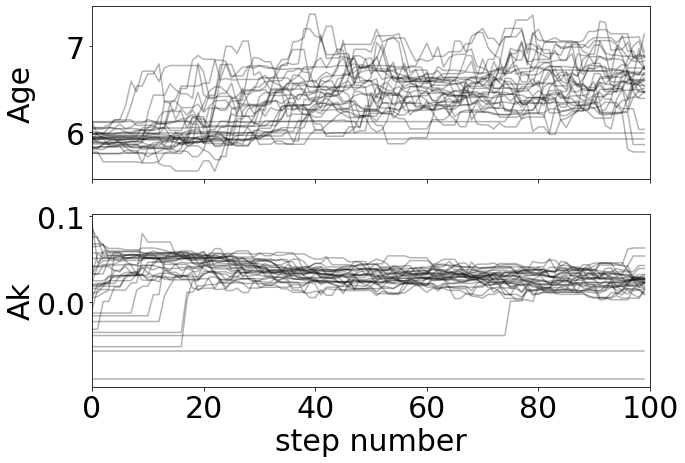

AssertionError: I don't believe that you want more dimensions than samples!

In [69]:
from IPython.display import display, Math

fig, axes = plt.subplots(2,figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r'Age', r'Ak']
for j in range(pos.shape[1]):
    ax = axes[j]
    ax.plot(samples[:, :, j], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[j])
    
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.savefig('sampler_output.pdf',bbox_inches='tight')
plt.show()
    
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
    
fig = corner.corner(flat_samples, truths=[11.39,gcs['AK_TARG'][1000]], labels=labels)
# fig.text(0.2,0.89,r'{}'.format(labs[i]),fontsize=12)
plt.savefig('age_ak.pdf',bbox_inches='tight')
plt.show()

for k in range(pos.shape[1]):
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(np.median(flat_samples[:,k]), mad(flat_samples[:,k]), mad(flat_samples[:,k]), labels[k])
    display(Math(txt))

In [64]:
7.3295+3.4477

10.7772

In [65]:
4.7126-2.3905

2.3221000000000003

In [67]:
gcs['APOGEE_ID'][idx]

'2M13413631+2821243'